# **Regularized Logistic Regression With Cross-Validation Evaluation**

### Author: Jiaqi Zhang

### Introduction
In this code, I'll implement Binary Logistic Regression with
regularization to perform classification. This classification task is to
predict whether or not a given patient has breast cancer based on health
data. The regularization method that I will be using is Tikhonov
regularization (L2 norm). I will also do cross-validation to evaluate and determine the best hyperparameter.

### UCI Breast Cancer Wisconsin (Diagnostic) Data Set 

I use a preprocessed version of the Breast Cancer Wisconsin
(Diagnostic) Data Set from UC Irvine's Machine Learning Repository site.
One can read more about the dataset here at
<https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)>.


## Math


### **Binary Logistic Regression**

The binary logistic regression model will perform the following:

$$h(x) = \frac{1}{1 + e^{-<w, x>}}$$

where $w$ is the model's weights and $h(x)$ is the probability that the
data point $x$ has a label of 1. 


The loss function will be Binary Log Loss, also called Binary Cross
Entropy Loss:

$$L_S(h) = -\frac{1}{m} \sum_{i=1}^m (y_i \log h(x_i) + (1 - y_i)\log (1 - h(x_i)))$$

on a sample $S$ of $m$ data points. Therefore, the corresponding
gradient of the Binary Log loss with respect to the model's weights is:
$$\frac{\partial L_S(h)}{\partial w_j} = \frac{1}{m} \sum_{i=1}^m (h(x_i) - y_i)x_{ij}$$

### **Regularize with Tikhonov Regularization**

As mentioned in the introduction part, with Tikhonov regularization, the L2 norm of the weights is:
$$\lambda||w||_2^2 = \lambda\sum_{i=1}^{d}w_i^2$$ 

With that added, the gradient used to update the weights has to be adjusted to include
$$\frac{\partial \lambda\sum_{i=1}^{d}w_i^2}{\partial w_j} = 2\lambda w_j$$
Notice that the $\lambda$ parameter above is used to control the
contribution of the regularization term to the overall learning process
that one may have to tune a little bit when implementing the code.

## **Model**

In [9]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

def sigmoid_function(x):
    return 1.0 / (1.0 + np.exp(-x))

class RegularizedLogisticRegression(object):
    '''
    Implement regularized logistic regression for binary classification.
    The weight vector w should be learned by minimizing the regularized loss
    L(h, (x,y)) = log(1 + exp(-y <w, x>)) + lambda |w|_2^2. In other words, the objective
    function that we are trying to minimize is the log loss for binary logistic regression 
    plus Tikhonov regularization with a coefficient of lambda.
    '''
    def __init__(self, batch_size = 15):
        self.learningRate = 0.00001 
        self.num_epochs = 10000 
        self.batch_size = batch_size 
        self.weights = None
        self.lmbda = 1 

    def train(self, X, Y):
        '''
        Train the model, using batch stochastic gradient descent
        @params:
            X: a 2D Numpy array where each row contains an example, padded by 1 column for the bias
            Y: a 1D Numpy array containing the corresponding labels for each example
        @return:
            None
        '''
        R, C = X.shape
        self.weights = np.zeros(C, dtype=float)
        
        for iter in range(self.num_epochs):
            idx = np.random.permutation(R)
            X = X[idx]
            Y = Y[idx]
            for t in range(int(np.ceil(len(Y) / self.batch_size))):
                X_batch = X[t * self.batch_size : (t + 1) * self.batch_size]
                Y_batch = Y[t * self.batch_size : (t + 1) * self.batch_size]
                z = X_batch @ self.weights          
                h = sigmoid_function(z)             
                gradient_R = (X_batch.T @ (h - Y_batch)) / len(Y_batch) 

                gradient_R += 2.0 * self.lmbda * self.weights  
                self.weights -= self.learningRate * gradient_R

        self.weights = self.weights.reshape(1, -1)

    def predict(self, X):
        '''
        Compute predictions based on the learned parameters and examples X
        @params:
            X: a 2D Numpy array where each row contains an example, padded by 1 column for the bias
        @return:
            A 1D Numpy array with one element for each row in X containing the predicted class.
        '''
        prediction = X @ self.weights.T
        prediction = sigmoid_function(prediction)
        prediction = np.ravel(prediction)
        
        for i in range(len(prediction)):
            if prediction[i] >= 0.5:
                prediction[i] = 1
            else:
                prediction[i] = 0
                
        return prediction
        
        

    def accuracy(self,X, Y):
        '''
        Output the accuracy of the trained model on a given testing dataset X and labels Y.
        @params:
            X: a 2D Numpy array where each row contains an example, padded by 1 column for the bias
            Y: a 1D Numpy array containing the corresponding labels for each example
        @return:
            a float number indicating accuracy (between 0 and 1)
        '''
        num_correct = 0.0
        prediction = self.predict(X)
        for i in range(len(prediction)):
            if prediction[i] == Y[i]:
                num_correct += 1

        accu_rate = num_correct / len(prediction)
        return accu_rate

    def runTrainTestValSplit(self, lambda_list, X_train, Y_train, X_val, Y_val):
        '''
        Given the training and validation data, fit the model with training data and test it with
        respect to each lambda. Record the training error and validation error, which are equivalent 
        to (1 - accuracy).
        @params:
            lambda_list: a list of lambdas
            X_train: a 2D Numpy array for trainig where each row contains an example,
            padded by 1 column for the bias
            Y_train: a 1D Numpy array for training containing the corresponding labels for each example
            X_val: a 2D Numpy array for validation where each row contains an example,
            padded by 1 column for the bias
            Y_val: a 1D Numpy array for validation containing the corresponding labels for each example
        @returns:
            train_errors: a list of training errors with respect to the lambda_list
            val_errors: a list of validation errors with respect to the lambda_list
        '''
        train_errors = []
        val_errors = []
        
        for l in lambda_list:
            self.lmbda = l
            self.train(X_train, Y_train)
            train_accur = self.accuracy(X_train, Y_train)
            error_train = 1.0 - train_accur
            train_errors.append(error_train)
            val_accur = self.accuracy(X_val, Y_val)
            error_val = 1.0 - val_accur
            val_errors.append(error_val)

        return train_errors, val_errors

    def _kFoldSplitIndices(self, dataset, k):
        '''
        Helper function for k-fold cross validation. Evenly split the indices of a
        dataset into k groups.
        For example, indices = [0, 1, 2, 3] with k = 2 may have an output
        indices_split = [[1, 3], [2, 0]].
        
        @params:
            dataset: a Numpy array where each row contains an example
            k: an integer, which is the number of folds
        @return:
            indices_split: a list containing k groups of indices
        '''
        num_data = dataset.shape[0]
        fold_size = int(num_data / k)
        indices = np.arange(num_data)
        np.random.shuffle(indices)
        indices_split = np.split(indices[:fold_size*k], k)
        return indices_split

    def runKFold(self, lambda_list, X, Y, k = 3):
        '''
        Run k-fold cross validation on X and Y with respect to each lambda. Return all k-fold
        errors.
        
        Each run of k-fold involves k iterations. For an arbitrary iteration i, the i-th fold is
        used as testing data while the rest k-1 folds are combined as one set of training data. The k results are
        averaged as the cross validation error.
        @params:
            lambda_list: a list of lambdas
            X: a 2D Numpy array where each row contains an example, padded by 1 column for the bias
            Y: a 1D Numpy array containing the corresponding labels for each example
            k: an integer, which is the number of folds, k is 3 by default
        @return:
            k_fold_errors: a list of k-fold errors with respect to the lambda_list
        '''
        k_fold_errors = []
        indices_split = self._kFoldSplitIndices(X, k)
        
        for lmbda in lambda_list:
            self.lmbda = lmbda

            k_folds_err_list = []
            
            for i in range(k):
                train_idx = np.array([], dtype=int)
                for j in range(k):
                    if j != i:
                        train_idx = np.concatenate((train_idx, indices_split[j]), axis=None)
                        
                X_train = X[train_idx]
                Y_train = Y[train_idx]
                val_idx = indices_split[i]
                X_val = X[val_idx]
                Y_val = Y[val_idx]
                self.train(X_train, Y_train)
                val_accur = self.accuracy(X_val, Y_val)
                error_val = 1.0 - val_accur
                k_folds_err_list.append(error_val)

            mean_k_fold_error = float(np.mean(k_folds_err_list))
            k_fold_errors.append(mean_k_fold_error)

        return k_fold_errors

    def plotError(self, lambda_list, train_errors, val_errors, k_fold_errors):
        '''
        Produce a plot of the cost function on the training and validation sets, and the
        cost function of k-fold with respect to the regularization parameter lambda. Use this plot
        to determine a valid lambda.
        @params:
            lambda_list: a list of lambdas
            train_errors: a list of training errors with respect to the lambda_list
            val_errors: a list of validation errors with respect to the lambda_list
            k_fold_errors: a list of k-fold errors with respect to the lambda_list
        @return:
            None
        '''
        plt.figure()
        plt.semilogx(lambda_list, train_errors, label = 'training error')
        plt.semilogx(lambda_list, val_errors, label = 'validation error')
        plt.semilogx(lambda_list, k_fold_errors, label = 'k-fold error')
        plt.xlabel('lambda')
        plt.ylabel('error')
        plt.legend()
        plt.show()

## **Check Model**

In [10]:
import pytest
# Sets random seed for testing purposes
np.random.seed(0)
random.seed(0)

# Creates Test Models
test_model1 = RegularizedLogisticRegression(3)
test_model2 = RegularizedLogisticRegression(3)

# Creates Test Data
x_bias = np.array([[0,4,1], [0,3,1], [5,0,1], [4,1,1], [0,5,1]])
y = np.array([0,0,1,1,0])
x_bias_test = np.array([[0,0,1], [-5,3,1], [9,0,1], [1,0,1], [6,-7,1]])
y_test = np.array([0,0,1,0,1])

x_bias2 = np.array([[0,0,1], [0,3,1], [4,0,1], [6,1,1], [0,1,1], [0,4,1]])
y2 = np.array([0,1,1,1,0,1])
x_bias_test2 = np.array([[0,0,1], [-5,-3,1], [9,0,1], [1,0,1]])
y_test2 = np.array([0,0,1,0])


# Test Train Model and Checks Model Weights
test_model1.train(x_bias, y)
weights1 = test_model1.weights
assert isinstance(weights1, np.ndarray)
assert weights1.ndim==2 and weights1.shape == (1,3)
assert weights1 == pytest.approx(np.array([[0.12661045, -0.14658517, -0.01241918]]), 0.05)

test_model2.train(x_bias2, y2)
weights2 = test_model2.weights
assert isinstance(weights2, np.ndarray)
assert weights2.ndim==2 and weights2.shape == (1,3)
assert weights2 == pytest.approx(np.array([[0.11113, 0.08361, 0.01943]]), 0.05) 

# Test Model Predict
predict1 = test_model1.predict(x_bias_test)
assert isinstance(predict1, np.ndarray)
assert predict1.ndim==1 and predict1.shape==(5,)
assert (predict1 == np.array([0, 0, 1, 1, 1])).all()

predict2 = test_model2.predict(x_bias_test2)
assert isinstance(predict2, np.ndarray)
assert predict2.ndim==1 and predict2.shape==(4,)
assert (test_model2.predict(x_bias_test2) == np.array([1, 0, 1, 1])).all()

# Test Model Accuracy
accuracy1 = test_model1.accuracy(x_bias_test, y_test)
assert isinstance(accuracy1, float)
assert accuracy1 == .8

accuracy2 = test_model2.accuracy(x_bias_test2, y_test2)
assert isinstance(accuracy2, float)
assert accuracy2 == .5

from datetime import date
print("Jiaqi Zhang ", date.today())

Jiaqi Zhang  2026-01-22


## **Main**

Train Accuracy: 0.9406593406593406
Validation Accuracy: 0.9649122807017544
[1000, 100, 10, 1, 0.1, 0.01, 0.001]
train error: [0.07472527472527468, 0.07252747252747249, 0.07252747252747249, 0.05934065934065935, 0.03516483516483515, 0.03516483516483515, 0.03516483516483515], validation error: [0.03508771929824561, 0.03508771929824561, 0.03508771929824561, 0.03508771929824561, 0.02631578947368418, 0.02631578947368418, 0.02631578947368418], k fold error: [0.0687830687830688, 0.0687830687830688, 0.0652557319223986, 0.054673721340388025, 0.042328042328042326, 0.04056437389770725, 0.04056437389770725]


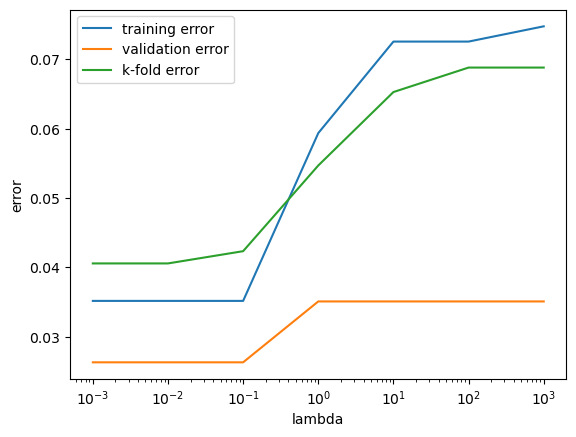

In [11]:
def extract():
    X_train = pd.read_csv('data/X_train.csv',header=None)
    Y_train = pd.read_csv('data/y_train.csv',header=None)
    X_val = pd.read_csv('data/X_val.csv',header=None)
    Y_val = pd.read_csv('data/y_val.csv',header=None)

    Y_train = np.array([i[0] for i in Y_train.values])
    Y_val = np.array([i[0] for i in Y_val.values])

    X_train = np.append(X_train, np.ones((len(X_train), 1)), axis=1)
    X_val = np.append(X_val, np.ones((len(X_val), 1)), axis=1)

    return X_train, X_val, Y_train, Y_val

def main():
    X_train, X_val, Y_train, Y_val = extract()
    X_train_val = np.concatenate((X_train, X_val))
    Y_train_val = np.concatenate((Y_train, Y_val))

    RR = RegularizedLogisticRegression()
    RR.train(X_train, Y_train)
    print('Train Accuracy: ' + str(RR.accuracy(X_train, Y_train)))
    print('Validation Accuracy: ' + str(RR.accuracy(X_val, Y_val)))
   
    lambda_list = [1000, 100, 10, 1, 0.1, 0.01, 0.001]
    train_errors, val_errors = RR.runTrainTestValSplit(lambda_list, X_train, Y_train, X_val, Y_val)
    k_fold_errors = RR.runKFold(lambda_list, X_train_val, Y_train_val, 3)
    print(lambda_list)
    print(f"train error: {train_errors}, validation error: {val_errors}, k fold error: {k_fold_errors}")    
    RR.plotError(lambda_list, train_errors, val_errors, k_fold_errors)
 
    
# Set random seeds.
np.random.seed(0)
random.seed(0)
main()

## **Results Report**

### **Investigation on the Regularization Constant and Bias-variance Trade-off**

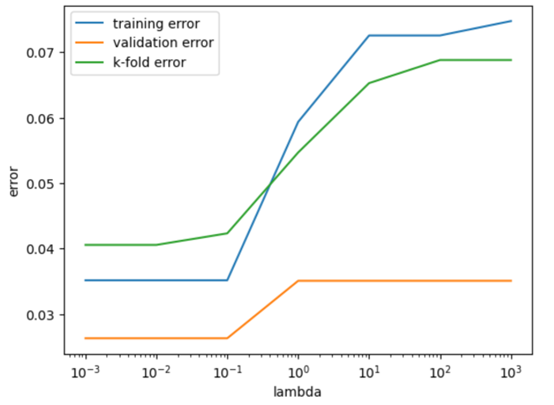

In [12]:
from IPython.display import Image, display
display(Image("Picture1.png"))

The validation and k-fold curves show the expected bias–variance trade-off: error is minimized near λ = 10⁻² and increases for larger λ as regularization becomes too strong (underfitting). The validation curve is relatively flat around the minimum, indicating the model is not overly sensitive to λ in that region. The k-fold error is consistently higher than the single validation split, which is expected because cross-validation averages across multiple data partitions and provides a more conservative estimate of generalization. The introduction of the regularization term effectively helps the model to generalize better (less likely to overfit) by adding a penalty term to suppress the very large weight values.